# Поиск клиентов с неоптимальными тарифами (телеком).

Дополнительные задания:

[__Дашборд__](https://public.tableau.com/app/profile/stepan8203/viz/Telecom_2_0/Dashboard1?publish=yes)

[__Презентация__](https://drive.google.com/file/d/1kwIIfhVVLbWIswBrzr3Ychm4ZSjPYDyI/view?usp=sharing)

Проект предполагает исследование данных по использованию услуг телефонии. Клиенты компании - колл-центры. 

__Цель проекта - определить стратегию перевода клиентов использующих неоптимальные тарифы на более выгодные для уменьшения оттока и увеличения LTV с минимальными потерями выручки для компании.__



__Содержание:__

Проект предполагает следующие этапы:

* **1. Загрузка и предобработка данных.**
 * 1.1. Общая информация о данных.
 * 2.1. Работа с дубликатами и пропусками
 * 3.1. Изменение формата данных

* **2. EDA Исследовательский анализ.**
 * 2.1. Временной промежуток исследования
 * 2.2. Продолжительность и количество звонков
 * 3.2. Количество операторов
 * 4.2. Пропущенные звонки
 * 5.2. Вывод

* **3. Определение числа активных клиентов**
 * 3.1.Вывод
  
* **4. Расчет выручки и определение перспективного тарифа**
 * 4.1. Расчет стоимости минут
 * 4.2. Расчет абонентской платы
   * 4.2.1 Текущий тариф
   * 4.2.2. Все тарифы
 * 4.3. Определение более выгодного тарифа
 * 4.4. Выручка на текущем тарифе
 * 4.5. Определение выручки по остальным тарифам
 * 4.6. Вывод
  
* **5.Минимизация потери выручки**
 * 5.1. Вывод

* **6. Проверка статистиеских гипотез**
 * 6.1. Выручка компании не изменится при полном переводе клиентов на оптимальные тарифы
 * 6.2. Выручка компании не изменится при частичном переводе клиентов на оптимальные тарифы


* **7. Общий вывод и ркомендации**

## Загрузка и предобработка данных.

### Общая информация о данных

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(15,5)}, font_scale=1.2, palette='GnBu_d')
import calendar 
from scipy import stats as st
from scipy.stats import levene
import math

Не получилось загрузить данные из архива через pd.read_csv('telecom_dataset.csv.zip') поэтому оставляю свои ссылки.

In [2]:
#загрузим данные
#df = pd.read_csv(r"C:\Users\79520\Downloads\telecom_dataset (1).csv")
#df_clients = pd.read_csv(r"C:\Users\79520\Downloads\telecom_clients (1).csv")

df = pd.read_csv("/datasets/telecom_dataset.csv")
df_clients = pd.read_csv("/datasets/telecom_clients.csv")

 **Описание данных:**

Датасеты содержат данные об использовании услуг виртуальной телефонии "Нупозвони". Клиентами "Нупозвони" являются организации, которым нужно распределять множество входящих вызовов на различных операторов, либо осуществлять исходящие вызовы силами операторов. Также операторы могут осуществлять внутренние вызовы, то есть вызовы друг между другом, которые осуществляются внутри сети виртуальной телефонии.

Колонки в *telecom_dataset.csv.zip*:

- `user_id` — идентификатор клиента,
- `date` — дата статистики;
- `direction` — направление вызовов: `out` — исходящий вызов, `in` — входящий;
- `internal` — маркер внутренних и внешних вызовов;
- `operator_id` — идентификатор оператора;
- `is_missed_call` — маркер пропущенных вызовов;
- `calls_count` — количество звонков;
- `call_duration` — длительность звонка без учёта времени ожидания;
- `total_call_duration` — длительность звонка с учётом времени ожидания.

Колонки в *telecom_clients.csv:*

- `user_id` — идентификатор клиента,
- `tariff_plan` — тарифный план клиента,
- `date_start` — дата регистрации клиента в сервисе.


In [3]:
df.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


### Работа с дубликатами и пропусками

In [5]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [6]:
df_clients.duplicated().sum()

0

In [7]:
#изучим пропущенные значения
df[df['internal'].isna()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1007,166405,2019-09-18 00:00:00+03:00,in,NaN,NaN,True,1,0,59
1090,166405,2019-10-01 00:00:00+03:00,in,NaN,NaN,True,1,0,1
1864,166406,2019-08-20 00:00:00+03:00,in,NaN,NaN,True,1,0,36
1924,166406,2019-09-02 00:00:00+03:00,in,NaN,879898.0,False,1,2,9
6210,166541,2019-09-26 00:00:00+03:00,in,NaN,908960.0,False,1,393,423
...,...,...,...,...,...,...,...,...,...
52462,168361,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,6,0,14
52590,168361,2019-11-13 00:00:00+03:00,in,NaN,NaN,True,2,0,6
52621,168361,2019-11-14 00:00:00+03:00,in,NaN,NaN,True,1,0,2
53717,168579,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,1,0,18


In [8]:
df_clients.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

В данных больщое колиество пропусков  в поле 'operator_id' удалив данные потеряем большую часть для анализа, решение - заменим пропуски маркером.

In [9]:
df.isna().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [10]:
# выделим дубликаты
df.duplicated().sum()

4900

In [11]:
# удалим дублирующиеся строки
df = df.drop_duplicates()
df.duplicated().sum()

0

### Изменение формата данных

In [12]:
# приведем дату к правильному формату, оставитм год,месяц, число
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [93]:
#так же преобразуем в object user_id
df['user_id'] = df['user_id'].astype('str')
df_clients['user_id'] = df_clients['user_id'].astype('str')

In [15]:
df.isna().sum()

user_id                   0
date                      0
direction                 0
internal                110
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [16]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null object
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: object(3)
memory usage: 17.3+ KB


### Вывод.

Данные представлены в двух таблицах.
telecom_dataset - с основными данными по пользовательской активности клиентоав и
telecom_clients - данный о тарифах и начале использования 

Основной датасет telecom_dataset - содержит 53785 строк
Фрейм с информацией о тарифах- telecom_clients - 732 строки

В результате предварительной предобработки данных удалось установить, что в данных 'telecom_dataset' имеется большое количество полных дубликатов - 4900, скорее всего возникли на этапе фиксации - сбора информации о пользователях. Полные дубликаты были удалены.

Нулевый значения обнаружены в датасете telecom_dataset в полях:

internal - 117
operator_id - 8172

Нулевые значения в строках на входящих пропущенных звонках, скорее всего звонок не был распеределен на конкретного оператора, поэтому не было зафиксировано фиксированного id.

Поле internal (признак внутреннего звонка) - незначительное количество пропусков, не требует предобработки.
Поле - operator_id - большое количество пропусков, удаление или замена значительно полвияют на результаты, так же оставляем без имзенений.

Данные были преведены к корекнтым форматам: изменение формата дат, изменение поля user_id до формата object.

## EDA (исследовательский анализ данных)

### Временной промежуток исследования.

In [17]:
print('Начало периода ', df['date'].min())
print('Конец периода', df['date'].max())


Начало периода  2019-08-02 00:00:00
Конец периода 2019-11-28 00:00:00


В данный представлена информация за промежуток - с 2019-08-02 по 2019-11-28. Будем счить что интервал - четыре месяца с августа по по ноябрь.

### Продолжительность и количество звонков

In [18]:
# посмотрим на медианную продолжительность звонков в день
df.groupby(['date','operator_id'])['total_call_duration'].sum().median()

868.0

In [19]:
# так же посмотрим на продолжительность звонков конкретного оператора в конкретную дату
df[(df['operator_id'] == '957922') & (df['date'] == '2019-11-15')]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration


Иходя из анализа очевидно, что время указано в секундах, для удобства переведем его в минуты

In [20]:
df['call_duration'] = df['call_duration']/60
df['total_call_duration'] = df['total_call_duration']/60

In [21]:
#проверим получившиеся значенияв аггрегации по сутками на конкретного оператора, отсортируем значения по убыванию
df_grouped = df.groupby(['date','user_id','operator_id'])[['call_duration','total_call_duration']].sum().reset_index().sort_values(by ='total_call_duration', ascending = False)
df_grouped.head(5)

,date,user_id,operator_id,call_duration,total_call_duration
3138,2019-09-25,166582,885876.0,2416.766667,3166.483333
3338,2019-09-26,166582,885876.0,2285.633333,2869.416667
1265,2019-09-09,166582,885876.0,2042.016667,2680.433333
2257,2019-09-18,166582,885876.0,2030.600000,2652.966667
4296,2019-10-02,166582,885876.0,2035.133333,2590.033333


In [22]:
#видим аномальные значения у одного пользователя, хотя медианное значение вполне похоже реальное, дополнительно рассмотри клиента с аномальными значениями
user_166582 = df_grouped[df_grouped['user_id'] == 166582]
user_166582[user_166582['call_duration']!= 0].sort_values(by = 'call_duration', ascending = False).head(5)

,date,user_id,operator_id,call_duration,total_call_duration


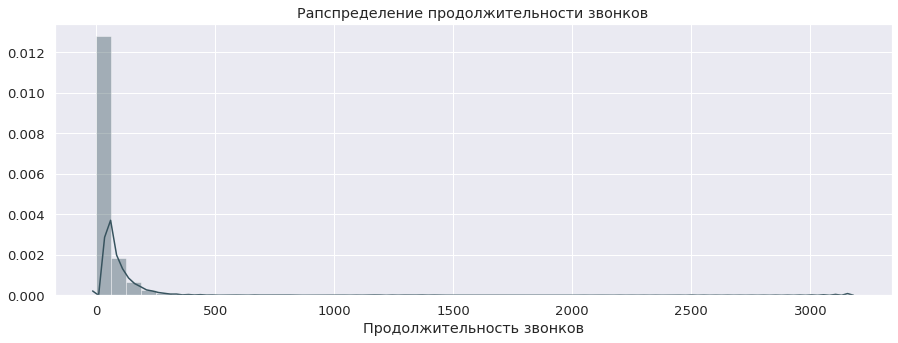

In [23]:
#рассмотрим распределение на гистограмме
sns.distplot(df.groupby(['date','operator_id'])['total_call_duration'].sum())
plt.title('Рапспределение продолжительности звонков')
plt.xlabel('Продолжительность звонков')
plt.show()

Видим большой выброс справа, более детально изучим данные.

In [24]:
#посмотри на выборку из остальных пользователей
df_grouped[df_grouped['user_id'] != 166582]

,date,user_id,operator_id,call_duration,total_call_duration
3138,2019-09-25,166582,885876.0,2416.766667,3166.483333
3338,2019-09-26,166582,885876.0,2285.633333,2869.416667
1265,2019-09-09,166582,885876.0,2042.016667,2680.433333
2257,2019-09-18,166582,885876.0,2030.600000,2652.966667
4296,2019-10-02,166582,885876.0,2035.133333,2590.033333
...,...,...,...,...,...
426,2019-08-27,166688,890228.0,0.000000,0.000000
3262,2019-09-25,167359,915360.0,0.000000,0.000000
13767,2019-11-11,168228,939684.0,0.000000,0.000000
11387,2019-11-01,168412,952458.0,0.000000,0.000000


В данных по продолжительности звонков было обнаружено большое количество аномальных значений. Продолжительность звонков больше чем 600 минут (10 часов рабочего времени). Есть несколько предположений.

1. У некоторых клиентов данные фиксируются некорректо, возможно в милисекундах, можно исправить аномальные значения разеделив аномальные длителности на 60.

2. Некоторые клиенты используют одну учетную запись для нескольких операторов, таким образом пытаясь съкономить на плате за каждого оператора. 

Для первого предположения недостаточно данных, исправление может значительно повлиять на результаты исследований. Примем тот факт, что данные фиксируются корректно, поэтому выбираем предположение о перерасходе из-за использования учетной записи несколькими операторами. 

Выведя данные из анализа потеряем большую часть дохода, принимаем решению для рассчета выручки оставить данные без изменения, для описания стандартного клиента будет использовать очищенные данные.

In [25]:
# Определим список клиентов спродолжительностью звонков  > 9  часов в день
abnormal_users = pd.Series(df_grouped[df_grouped['call_duration'] > 480]['user_id'].unique()).to_list()
abnormal_users

['166582', '167827', '168253']

In [26]:
df_cleaned = df.query('user_id not in @abnormal_users')

In [27]:
df_cleaned_not_null = df_cleaned[df_cleaned['call_duration'] > 0]

In [28]:
df_cleaned_not_null.groupby(['date', 'operator_id'])[['call_duration', 'total_call_duration']].sum()

call_duration  total_call_duration
date       operator_id                                    
2019-08-02 879896.0          0.516667             2.433333
           879898.0          2.200000             2.416667
2019-08-03 879896.0          0.900000             2.133333
           879898.0         15.133333            17.716667
2019-08-04 879896.0          1.900000             2.066667
...                               ...                  ...
2019-11-28 971102.0         49.666667            57.283333
           972410.0         38.050000            42.533333
           972412.0         32.133333            36.383333
           972460.0         18.150000            21.100000
           973286.0          0.283333             1.750000

[18549 rows x 2 columns]

In [29]:
df_cleaned_not_null

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
3,166377,2019-08-05,out,True,880020.0,False,1,0.166667,0.300000
5,166377,2019-08-05,out,False,880020.0,False,2,0.050000,0.483333
13,166377,2019-08-06,out,False,880020.0,False,5,13.333333,13.650000
15,166377,2019-08-07,out,False,880026.0,False,1,0.350000,0.466667
16,166377,2019-08-07,out,False,880020.0,False,2,3.866667,4.000000
...,...,...,...,...,...,...,...,...,...
53892,168606,2019-11-08,out,False,957922.0,False,2,4.250000,5.466667
53894,168606,2019-11-08,in,False,957922.0,False,2,11.433333,11.750000
53895,168606,2019-11-09,out,False,957922.0,False,4,9.183333,9.883333
53898,168606,2019-11-11,out,True,957922.0,False,2,7.983333,8.350000


In [30]:
#cгрупируем данные для расчета средних значений по пользователям
df_cleaned_gpd = df_cleaned_not_null.groupby(['user_id', 'date','direction','internal'])[['calls_count', 'call_duration', 'total_call_duration']].sum().reset_index()
df_cleaned_gpd.groupby(['direction', 'internal'])[['calls_count','total_call_duration']].median().round().reset_index().drop(labels =[2], axis = 0)

,direction,internal,calls_count,total_call_duration
0,in,False,4,7.0
1,in,True,1,1.0
3,out,True,4,5.0


### Количество  операторов

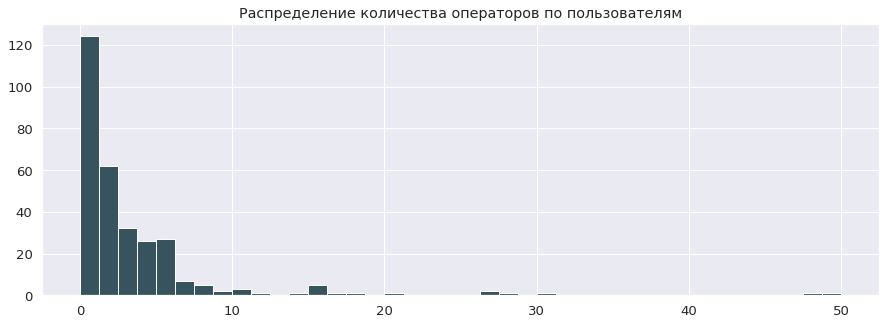

In [31]:
#изучим распределение количества операторов по пользователям
df_cleaned.groupby([ 'user_id'])['operator_id'].nunique().hist(bins =40)
plt.title('Распределение количества операторов по пользователям')
plt.show()

In [32]:
#определим среднее количетво операторов в у пользовтеля
print('Среднее количество операторов у пользователя: ', df_cleaned.groupby('user_id')['operator_id'].nunique().median())
print('Среднее количество операторов в день: ', df_cleaned.groupby(['date', 'user_id'])['operator_id'].nunique().median())

Среднее количество операторов у пользователя:  2.0
Среднее количество операторов в день:  1.0


### Пропущенные звонки

Дополнительно рассмотрим информацию по количеству попущенных звонков

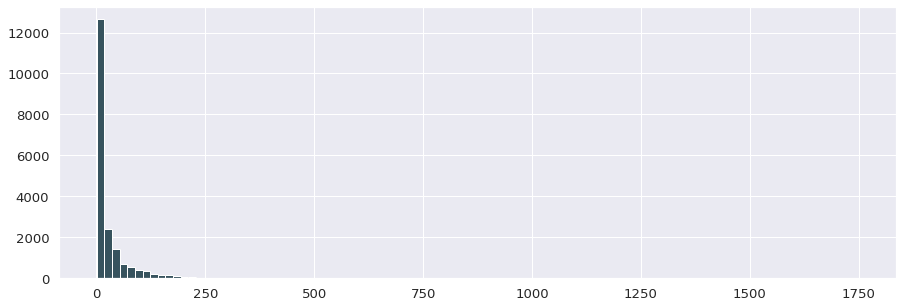

In [33]:
#изучем распределнеи по общему количеству звонков на оператора в день
df_cleaned.groupby(['date','operator_id'])['calls_count'].sum().hist(bins =100)

Распределения так же имеет большие выбросы, для анализа будем использовать медианное значение.

In [34]:
df_missed  = df_cleaned.groupby(['date','operator_id', 'is_missed_call'])['calls_count'].sum().reset_index()
df_missed.groupby('is_missed_call')['calls_count'].median().reset_index()


,is_missed_call,calls_count
0,False,7
1,True,5


### Вывод

В данном разделе были подробно изученные предоставленные данный, для определения портрета типичного клиента данный были предобработы путем исключения клиентов с ненормальной активностью. Для расчета времени звонка не учитываличь нулевые значения. 

Данные по аномальным пользователям, обнаруженным в результате исследования было принято не удалять т.к. удаление могло значительно повлиять при расчете прибыли.

На основании рассмотренных предобработанных данныйх был составлен портрет среднего пользователя.

В среднем клиент использует в работе 3 -х операторов в смене, как правиоло работают 2 сотрудника. 

В день один сотрудник в среднем 

__совершает:__

- 11 исходящих звонков на внешние номера общей длительностью 19 минут
- 4 исходящих звонка на внутренние номера общей длительностью 5 минут

__принимает:__

- 4 звонка с внешних номеров общей длительностью 3 минуты
- 1 звонок с внутренних номеров общей длительностью 1 минута

В среднем 5 звонков на сотрудника в день являются пропущенными.

## Определение числа активных клиентов.

Для дальнейшего исследования необходимо определить активных клиентов, активными будем считать клиентов, совершивших хотя бы 10 звонков за последние 30 дней.

In [35]:
#прежде всего определим общее количество пользователей
df['user_id'].nunique()

307

In [36]:
#определим необходимую дату 
dt_not_activ = df['date'].max() - timedelta(days=30)

In [37]:
dt_not_activ

Timestamp('2019-10-29 00:00:00')

In [38]:
#выведем список пользователей не совершивших ни один звонок за последнии 30 дней
df_last_month = df[df['date']>= dt_not_activ]

#сгруппирум данные в интервале по количеству звонков
df_last_month_grpd = df_last_month.groupby('user_id')['calls_count'].sum().reset_index()

#выведем список не активных пользователей
not_activ_users = df_last_month_grpd[df_last_month_grpd['calls_count'] < 10]['user_id'].to_list()

#создадим столбец с флагом неактивности, переведем значения True, False в 1,0
df['not_activ'] = df['user_id'].isin(not_activ_users)*1


print('Количество неактивных клиентов: ', len(not_activ_users))

Количество неактивных клиентов:  45


In [39]:
#отобразим долю потерянных строк при исключении из анализа неактивных пользователей
(len(df[df['not_activ'] == 1])/len(df))*100

1.7938043345169585

В последующем исследовании все расчеты будем вести с активными пользовтателями (совершали 10 и больше звонков за последний месяц). 

In [40]:
#выделим активных клиентов в отдельный фрейм
df_active = df[df['not_activ'] == 0]


### Вывод.

В результате дополнительной предоработки данные были очищены от клиентов не использующих услуги.
Критерий отбора - активным клиентом считаем тех клиентов, которые в течение последних 30-ти дней совершили 10 и больше звонков.

В результати применения критерия было выявлено 45  неактивных пользователей.

Количество строк в данных уменьшилось на 1.8%, что является допустимым показателем для сохранения объективности при дальнейшем подсчете.

## Расчет выручки и определение перспективного тарифа

In [41]:
#отдельно выделим столбец с месяцем
df_active['month'] = df_active['date'].astype('datetime64[M]')

In [42]:
 df_active['date'][3]

Timestamp('2019-08-05 00:00:00')

In [43]:
#для дальнеших расчетов сгруппируем данные по необходимым полям
df_active_agg = df_active.groupby(['month', 'user_id', 'direction','internal']).agg({'operator_id': 'nunique', 'calls_count': 'sum', 'call_duration': 'sum', 'total_call_duration': 'sum'}).reset_index()

In [44]:
df_active

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,not_activ,month
0,166377,2019-08-04,in,False,NaN,True,2,0.000000,0.066667,0,2019-08-01
1,166377,2019-08-05,out,True,880022.0,True,3,0.000000,0.083333,0,2019-08-01
2,166377,2019-08-05,out,True,880020.0,True,1,0.000000,0.016667,0,2019-08-01
3,166377,2019-08-05,out,True,880020.0,False,1,0.166667,0.300000,0,2019-08-01
4,166377,2019-08-05,out,False,880022.0,True,3,0.000000,0.416667,0,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...
53896,168606,2019-11-10,out,True,957922.0,False,1,0.000000,0.416667,0,2019-11-01
53897,168606,2019-11-10,out,True,957922.0,True,1,0.000000,0.633333,0,2019-11-01
53898,168606,2019-11-11,out,True,957922.0,False,2,7.983333,8.350000,0,2019-11-01
53899,168606,2019-11-15,out,True,957922.0,False,4,52.166667,53.166667,0,2019-11-01


In [45]:
#присоеденим данный с информацией о тарифах
df_revenue = df_active.merge(df_clients, on ='user_id')
df_revenue.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,not_activ,month,tariff_plan,date_start
0,166377,2019-08-04,in,False,NaN,True,2,0.0,0.066667,0,2019-08-01,B,2019-08-01
1,166377,2019-08-05,out,True,880022.0,True,3,0.0,0.083333,0,2019-08-01,B,2019-08-01
2,166377,2019-08-05,out,True,880020.0,True,1,0.0,0.016667,0,2019-08-01,B,2019-08-01


In [46]:
#окргулим значения вверх по правилам телекома
df_revenue['total_call_duration'] = df_revenue['total_call_duration']
df_revenue['call_duration'] = df_revenue['call_duration']

### Расчет стоимости минут 

In [47]:
# определим стоимость по за минуты по текущему тарифц пользователей
tariffs = ['A', 'B','C']
calls_out_inner =[0.1, 0.15, 0.3]
calls_out_outer =[0.4, 0.5, 0.7]

def func(row):
    for i in range(3):
        if row['direction'] == 'in' and \
        row['tariff_plan'] == tariffs[i] and  \
        row['internal'] == True and  \
        row['total_call_duration']>2000:
            return (row['total_call_duration']-2000) *calls_out_inner[i]
        
        if row['direction'] == 'out' and \
            row['tariff_plan'] == tariffs[i] and \
            row['internal'] == False:
            return (row['total_call_duration']) *calls_out_outer[i]
        
    else: return 0


df_revenue['rev_per_minute'] = df_revenue.apply(func, axis= 1)
df_revenue['rev_per_minute'] = df_revenue['rev_per_minute'].round(2)

In [48]:
# определим стоимость минут для остальных тарифов
#в списках пропишем данные по тарифам
tariffs = ['A', 'B','C']
calls_out_inner =[0.1, 0.15, 0.3]
calls_out_outer =[0.4, 0.5, 0.7]

def func_A(row):
    if row['direction'] == 'in' and \
        row['internal'] == True and  \
        row['total_call_duration']>2000:
            return (row['total_call_duration']-2000) *0.1
        
    if row['direction'] == 'out' and \
           row['internal'] == False:
            return (row['total_call_duration']) * 0.4
        
    else: return 0
    
def func_B(row):
    if  row['direction'] == 'in' and \
        row['internal'] == True and  \
        row['total_call_duration']>2000:
            return (row['total_call_duration']-2000) *0.15
        
    if row['direction'] == 'out' and \
           row['internal'] == False:
            return (row['total_call_duration']) * 0.5
        
    else: return 0

def func_C(row):
    if  row['direction'] == 'in' and \
        row['internal'] == True and  \
        row['total_call_duration']>2000:
            return (row['total_call_duration']-2000) *0.3
        
    if row['direction'] == 'out' and \
           row['internal'] == False:
            return (row['total_call_duration'])*0.7
        
    else: return 0

In [49]:
# создадим столбцы со стоимостью за минуты для каждого тарифа
df_revenue['A'] = df_revenue.apply(func_A, axis= 1).round(2)
df_revenue['B'] = df_revenue.apply(func_B, axis= 1).round(2)
df_revenue['C'] = df_revenue.apply(func_C, axis= 1).round(2)


In [50]:
df_revenue.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,not_activ,month,tariff_plan,date_start,rev_per_minute,A,B,C
0,166377,2019-08-04,in,False,NaN,True,2,0.000000,0.066667,0,2019-08-01,B,2019-08-01,0.00,0.00,0.00,0.00
1,166377,2019-08-05,out,True,880022.0,True,3,0.000000,0.083333,0,2019-08-01,B,2019-08-01,0.00,0.00,0.00,0.00
2,166377,2019-08-05,out,True,880020.0,True,1,0.000000,0.016667,0,2019-08-01,B,2019-08-01,0.00,0.00,0.00,0.00
3,166377,2019-08-05,out,True,880020.0,False,1,0.166667,0.300000,0,2019-08-01,B,2019-08-01,0.00,0.00,0.00,0.00
4,166377,2019-08-05,out,False,880022.0,True,3,0.000000,0.416667,0,2019-08-01,B,2019-08-01,0.21,0.17,0.21,0.29


### Расчет абонентской платы

In [51]:
#перед группировкой помесяцам округлим данные вверх по праилам тарифов
df_revenue['A'] = np.ceil(df_revenue['A'])
df_revenue['B'] = np.ceil(df_revenue['B'])
df_revenue['C'] = np.ceil(df_revenue['C'])
df_revenue['rev_per_minute'] = np.ceil(df_revenue['rev_per_minute'])

In [52]:
#сгруппируем данные по месяцам
df_revenue_month = df_revenue.groupby(['month','user_id','tariff_plan']).agg({'operator_id': 'nunique','rev_per_minute':'sum','A':'sum','B':'sum','C':'sum'}).reset_index()
df_revenue_month.head(5)

,month,user_id,tariff_plan,operator_id,rev_per_minute,A,B,C
0,2019-08-01,166377,B,5,691.0,560.0,691.0,946.0
1,2019-08-01,166392,C,2,0.0,0.0,0.0,0.0
2,2019-08-01,166399,C,1,0.0,0.0,0.0,0.0
3,2019-08-01,166405,B,2,456.0,372.0,456.0,621.0
4,2019-08-01,166406,B,3,1343.0,1082.0,1343.0,1863.0


#### Текущий тариф

In [53]:
#расчет абонетской платы по тарифам
tariffs = ['A','B','C']
abons = [5000, 2000, 1000]

def fun_abon_curr(row):
    for a in range(3):
        if row['tariff_plan'] == tariffs[a]:
            return (row['operator_id']*100)+abons[a]
        if row['tariff_plan'] == tariffs[a]:
            return (row['operator_id']*100)+abons[a]
        if row['tariff_plan'] == tariffs[a]:
            return (row['operator_id']*100)+abons[a]
    else:
        return 0

In [54]:
df_revenue_month['abon_current'] = df_revenue_month.apply(fun_abon_curr, axis =1)

df_revenue_month.head(5)

,month,user_id,tariff_plan,operator_id,rev_per_minute,A,B,C,abon_current
0,2019-08-01,166377,B,5,691.0,560.0,691.0,946.0,2500
1,2019-08-01,166392,C,2,0.0,0.0,0.0,0.0,1200
2,2019-08-01,166399,C,1,0.0,0.0,0.0,0.0,1100
3,2019-08-01,166405,B,2,456.0,372.0,456.0,621.0,2200
4,2019-08-01,166406,B,3,1343.0,1082.0,1343.0,1863.0,2300


In [55]:
df_revenue_month.head(1)

,month,user_id,tariff_plan,operator_id,rev_per_minute,A,B,C,abon_current
0,2019-08-01,166377,B,5,691.0,560.0,691.0,946.0,2500


In [56]:
# ячейка ревьюера:
(df_active
 .query('user_id == "166377"')
 .groupby(['month', 'user_id'])
 .agg({'operator_id': 'nunique'})
)

,,operator_id
month,user_id,
2019-08-01,166377,5
2019-09-01,166377,4
2019-10-01,166377,5
2019-11-01,166377,4


In [90]:
# ячейка ревьюера:
(df_active
 .query('user_id == "166377" and operator_id != "111111"')
 .groupby(['month', 'user_id'])
 .agg({'operator_id': 'nunique'})
)

,,operator_id
month,user_id,
2019-08-01,166377,5
2019-09-01,166377,4
2019-10-01,166377,5
2019-11-01,166377,4


In [58]:
#создадим столбец с общей выручкой
df_revenue_month['total_rev'] = df_revenue_month['abon_current']  + df_revenue_month['rev_per_minute']

#### Все тарифы

In [59]:
#добавим столбцы с информацие об абонентской плате по всем тарифам
df_revenue_month['abon_A'] = (df_revenue_month['operator_id']*100)+5000
df_revenue_month['abon_B'] = (df_revenue_month['operator_id']*100)+2000
df_revenue_month['abon_C'] = (df_revenue_month['operator_id']*100)+1000
df_revenue_month.head(3)

,month,user_id,tariff_plan,operator_id,rev_per_minute,A,B,C,abon_current,total_rev,abon_A,abon_B,abon_C
0,2019-08-01,166377,B,5,691.0,560.0,691.0,946.0,2500,3191.0,5500,2500,1500
1,2019-08-01,166392,C,2,0.0,0.0,0.0,0.0,1200,1200.0,5200,2200,1200
2,2019-08-01,166399,C,1,0.0,0.0,0.0,0.0,1100,1100.0,5100,2100,1100


In [60]:
# так же добавим столбцы с общей выручкой по всем тарифам
df_revenue_month['total_A'] = df_revenue_month['A'] + df_revenue_month['abon_A']
df_revenue_month['total_B'] = df_revenue_month['B'] + df_revenue_month['abon_B']
df_revenue_month['total_C'] = df_revenue_month['C'] + df_revenue_month['abon_C']

In [61]:
df_revenue_month.head()

,month,user_id,tariff_plan,operator_id,rev_per_minute,A,B,C,abon_current,total_rev,abon_A,abon_B,abon_C,total_A,total_B,total_C
0,2019-08-01,166377,B,5,691.0,560.0,691.0,946.0,2500,3191.0,5500,2500,1500,6060.0,3191.0,2446.0
1,2019-08-01,166392,C,2,0.0,0.0,0.0,0.0,1200,1200.0,5200,2200,1200,5200.0,2200.0,1200.0
2,2019-08-01,166399,C,1,0.0,0.0,0.0,0.0,1100,1100.0,5100,2100,1100,5100.0,2100.0,1100.0
3,2019-08-01,166405,B,2,456.0,372.0,456.0,621.0,2200,2656.0,5200,2200,1200,5572.0,2656.0,1821.0
4,2019-08-01,166406,B,3,1343.0,1082.0,1343.0,1863.0,2300,3643.0,5300,2300,1300,6382.0,3643.0,3163.0


In [62]:
#оставим нужные для анализа столбцы
df_rev_total = df_revenue_month[['month', 'user_id', 'tariff_plan' , 'total_rev', 'total_A', 'total_B', 'total_C']]
df_rev_total.head(5)

,month,user_id,tariff_plan,total_rev,total_A,total_B,total_C
0,2019-08-01,166377,B,3191.0,6060.0,3191.0,2446.0
1,2019-08-01,166392,C,1200.0,5200.0,2200.0,1200.0
2,2019-08-01,166399,C,1100.0,5100.0,2100.0,1100.0
3,2019-08-01,166405,B,2656.0,5572.0,2656.0,1821.0
4,2019-08-01,166406,B,3643.0,6382.0,3643.0,3163.0


### Определение более выгодного тарифа

In [63]:
#определим функцию для выбора более выгодного тарифа 
def optimal_teriff(row):
    if row['total_A'] < row['total_B'] and row['total_B'] < row['total_C']:
        return 'A'
    elif row['total_B'] < row['total_A'] and row['total_A'] < row['total_C']:
        return 'B'
    elif row['total_C'] < row['total_B'] and row['total_B'] < row['total_A']:
        return 'C'
    elif row['total_A'] < row['total_C'] and row['total_C'] < row['total_B']:
        return 'A'
    elif row['total_C'] < row['total_A'] and row['total_A'] < row['total_B']:
        return 'C'    
    elif row['total_B'] < row['total_C'] and row['total_C'] < row['total_A']:
        return 'B' 
    else: 
        return 0

In [64]:
df_rev_total['optimal_teriff'] = df_rev_total.apply(optimal_teriff, axis =1)
df_rev_total.head(5)

,month,user_id,tariff_plan,total_rev,total_A,total_B,total_C,optimal_teriff
0,2019-08-01,166377,B,3191.0,6060.0,3191.0,2446.0,C
1,2019-08-01,166392,C,1200.0,5200.0,2200.0,1200.0,C
2,2019-08-01,166399,C,1100.0,5100.0,2100.0,1100.0,C
3,2019-08-01,166405,B,2656.0,5572.0,2656.0,1821.0,C
4,2019-08-01,166406,B,3643.0,6382.0,3643.0,3163.0,C


In [65]:
#отобразим количество рекомендованных тарифов
df_rev_total['optimal_teriff'].value_counts().reset_index()

,index,optimal_teriff
0,C,659
1,B,17
2,A,5


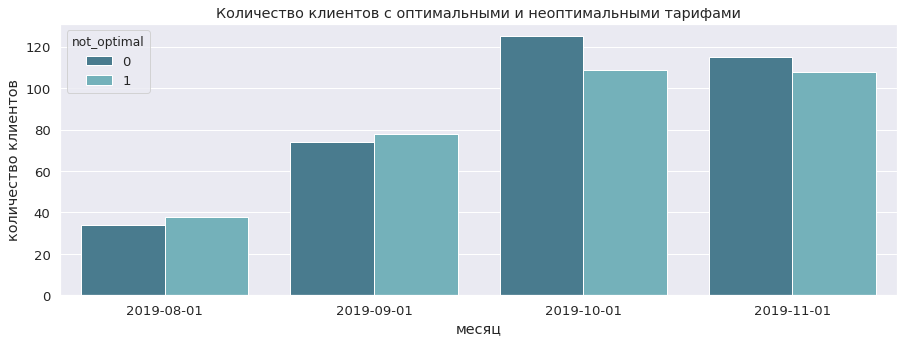

,month,optimal_teriff,not_optimal_teriff
0,2019-08-01,34,38
1,2019-09-01,74,78
2,2019-10-01,125,109
3,2019-11-01,115,108


In [66]:
#cгруппирем данные для отображения количества клиентnов с неоптимальными тарифами по месяцам
df_rev_total['not_optimal']= (df_rev_total['optimal_teriff'] != df_rev_total['tariff_plan'])*1
plot_optinmal_tariff = df_rev_total.groupby(['month','not_optimal'])['user_id'].nunique().reset_index()
# plot_optinmal_tariff['month'] = plot_optinmal_tariff['month'].apply(lambda x: calendar.month_name[x])
plot_optinmal_tariff['month'] = plot_optinmal_tariff['month'].astype('str')


sns.barplot(data = plot_optinmal_tariff, x = 'month', y  ='user_id', hue = 'not_optimal', palette='GnBu_d')
plt.title('Количество клиентов с оптимальными и неоптимальными тарифами')
plt.xlabel('месяц')
plt.ylabel('количество клиентов')
plt.show()
pivot_opt = plot_optinmal_tariff.pivot_table(columns = 'not_optimal', index ='month', values = 'user_id', aggfunc = 'sum').reset_index()
pivot_opt.columns = ['month', 'optimal_teriff', 'not_optimal_teriff']
display(pivot_opt)

In [67]:
plot_optinmal_tariff[plot_optinmal_tariff['not_optimal'] == 1]

,month,not_optimal,user_id
1,2019-08-01,1,38
3,2019-09-01,1,78
5,2019-10-01,1,109
7,2019-11-01,1,108


* Август, Сентябрь  - небольшое преобладание клиентов снепотимальными тарифами
* Октябрь, Ноябрь - большее количество клиентов соптимальными тарифами

### Выручка на текущем тарифе

,month,total_rev
0,2019-08-01,179880.0
1,2019-09-01,409065.0
2,2019-10-01,646086.0
3,2019-11-01,611284.0


Общая выручка на текущем тарифе: 1846315 рублей


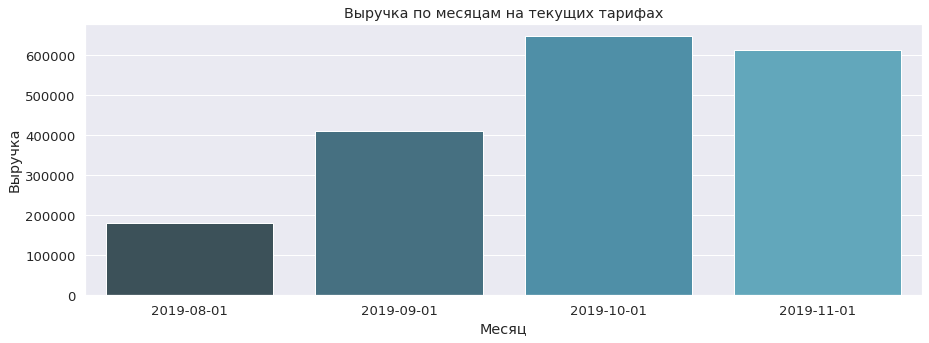

In [68]:
# расчитаем и визуализируем вырцчку на теукщем тарифе по месяцам
plot_tot_rev = df_rev_total.groupby('month')['total_rev'].sum().reset_index()

plot_tot_rev['month'] = plot_tot_rev['month'].astype('str')

sns.barplot(data = plot_tot_rev, x = 'month', y = 'total_rev')
plt.title('Выручка по месяцам на текущих тарифах')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
display(plot_tot_rev)

print('Общая выручка на текущем тарифе: {:.0f} рублей'.format(plot_tot_rev['total_rev'].sum()))

На графике можем наблюдать практически линейный рост выручки начиная с августа, однако пиковый месяц - октябрь - 646086 р

### Определение выручки по остальным тарифам

In [69]:
#изменим уже использованную функцию для определения выручки по оптимальным тарифам
def optimal_teriff_rev(row):
    if row['total_A'] < row['total_B'] and row['total_B'] < row['total_C']:
        return row['total_A']
    elif row['total_B'] < row['total_A'] and row['total_A'] < row['total_C']:
        return row['total_B']
    elif row['total_C'] < row['total_B'] and row['total_B'] < row['total_A']:
        return row['total_C'] 
    elif row['total_A'] < row['total_C'] and row['total_C'] < row['total_B']:
        return row['total_A']
    elif row['total_C'] < row['total_A'] and row['total_A'] < row['total_B']:
        return row['total_C']   
    elif row['total_B'] < row['total_C'] and row['total_C'] < row['total_A']:
        return row['total_B'] 
    else: 
        return 0


In [70]:
# создадим столбец с выручкой по оптимальным тарифам
df_rev_total['optimal_teriff_rev'] = df_rev_total.apply(optimal_teriff_rev, axis =1)
df_rev_total.head(3)

,month,user_id,tariff_plan,total_rev,total_A,total_B,total_C,optimal_teriff,not_optimal,optimal_teriff_rev
0,2019-08-01,166377,B,3191.0,6060.0,3191.0,2446.0,C,1,2446.0
1,2019-08-01,166392,C,1200.0,5200.0,2200.0,1200.0,C,0,1200.0
2,2019-08-01,166399,C,1100.0,5100.0,2100.0,1100.0,C,0,1100.0


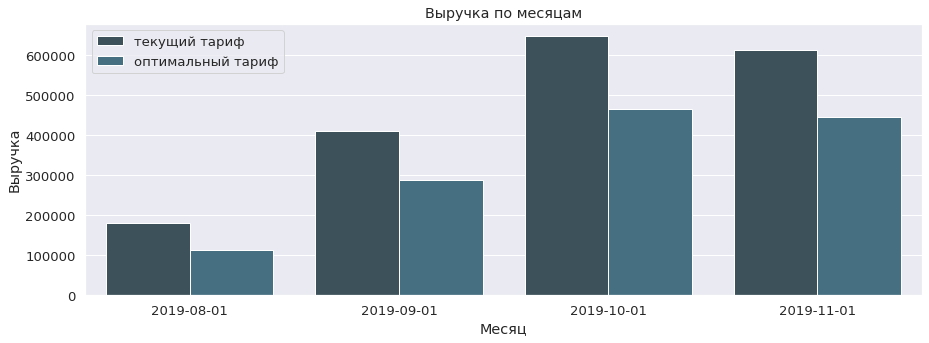

,month,total_rev,optimal_teriff_rev,diff,%
0,2019-08-01,179880.0,113496.0,66384.0,36.9
1,2019-09-01,409065.0,287319.0,121746.0,29.8
2,2019-10-01,646086.0,463999.0,182087.0,28.2
3,2019-11-01,611284.0,443792.0,167492.0,27.4


In [71]:
#построим график выручки по текущему и оптимальному тарифу
plot_tot_rev = df_rev_total.groupby('month')[['total_rev', 'optimal_teriff_rev']].sum().reset_index()
# # plot_tot_rev_optimal = df_rev_total.groupby('month')['optimal_teriff_rev'].sum().reset_index()

# sns.barplot(data = plot_tot_rev, x = 'month', y = 'total_rev', alpha = 0.5)
# sns.barplot(data = plot_tot_rev_optimal, x = 'month', y = 'optimal_teriff_rev', alpha = 1)


#преобразуем фрейм для удобства визуализации
a = plot_tot_rev[['month', 'total_rev']].reset_index(drop=True)
b = plot_tot_rev[['month', 'optimal_teriff_rev']].reset_index(drop=True)

a['type'] = 'текущий тариф'
b['type'] = 'оптимальный тариф'

a.columns = ['month', 'rev', 'type']
b.columns = ['month', 'rev', 'type']

df_plot = a.append(b)
df_plot = df_plot.reset_index(drop = True)

#так же переведем числовой формат месяца в название 
df_plot['month'] = df_plot['month'].astype('str')

sns.barplot(data = df_plot, x ='month', y ='rev', hue ='type') #order = ['August', 'September', 'October', 'November'] )
plt.legend()
plt.title('Выручка по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.show()

df_rev_total_grp = df_rev_total.groupby('month')[['total_rev', 'optimal_teriff_rev']].sum()
df_rev_total_grp['diff'] = df_rev_total_grp['total_rev'] - df_rev_total_grp['optimal_teriff_rev']
df_rev_total_grp['%'] = ((df_rev_total_grp['diff']/ df_rev_total_grp['total_rev'])*100).round(1)
df_rev_total_grp.reset_index()

In [72]:
print('Средний процент снижения выручки при использовании оптимального тарифа: {:.2f}'.format(df_rev_total_grp['%'].mean()))
print('Общая выручка на оптимальном тарифе: {:.0f} рублей'.format(df_rev_total_grp['optimal_teriff_rev'].sum()))

Средний процент снижения выручки при использовании оптимального тарифа: 30.58
Общая выручка на оптимальном тарифе: 1308606 рублей


### Вывод

В данном разделе был выявлен оптимальный для клиентов тариф,  расчитаны показатели прибыли на текущем и оптимальном тарифе, а так же определно количество пользователей использующих неоптимальные тарифы в разрезе месяцев.

* Общая выручка на текущем тарифе:  __1846315 рублей__

* Наибольшая в октябре -  __646086 рублей__
* Наименьшая в августе -  __179880 рублей__

Больше всего неоптимальными тарифами клиенты пользовались в октябре и ноябре - 108 и 109 клиентов с неоптимальными тарифами.

Чаще всего клиента выгоднее переходить на тариф С, данный тариф был чаще всего. Количество рекомендованных тарифов при импользовании неоптимального в месяц:
* C - 659
* B	- 17
* A	- 5

Размер общей выручки при использовании клиентами оптимальных тарифов - __1308606 рублей__

116870 -если сохраняем наны и 

В сравнении с текущим тарифом размер выручки меньше на __30.58%__


## Минимизация потери выручки

Для того, чтобы минимизировать потерю выручки предложим оптимальный тариф только 30 -ти процентам пользователей с неоптимальными тарифами, для 10%  пользователей с оптимальными тарифами предложим другой тариф (второй по оптимальности).

In [73]:
#изменим уже использованную функцию для определения выручки по оптимальным тарифам для определения тарифа второго по оптимальности
def second_optimal_teriff_rev(row):
    if row['total_A'] < row['total_B'] and row['total_B'] < row['total_C']:
        return row['total_B']
    elif row['total_B'] < row['total_A'] and row['total_A'] < row['total_C']:
        return row['total_A']
    elif row['total_C'] < row['total_B'] and row['total_B'] < row['total_A']:
        return row['total_B'] 
    elif row['total_A'] < row['total_C'] and row['total_C'] < row['total_B']:
        return row['total_C']
    elif row['total_C'] < row['total_A'] and row['total_A'] < row['total_B']:
        return row['total_A']   
    elif row['total_B'] < row['total_C'] and row['total_C'] < row['total_A']:
        return row['total_C'] 
    else: 
        return 0

In [74]:
df_rev_total['second_opt'] = df_rev_total.apply(second_optimal_teriff_rev, axis = 1)

In [75]:
df_rev_total.head(3)

,month,user_id,tariff_plan,total_rev,total_A,total_B,total_C,optimal_teriff,not_optimal,optimal_teriff_rev,second_opt
0,2019-08-01,166377,B,3191.0,6060.0,3191.0,2446.0,C,1,2446.0,3191.0
1,2019-08-01,166392,C,1200.0,5200.0,2200.0,1200.0,C,0,1200.0,2200.0
2,2019-08-01,166399,C,1100.0,5100.0,2100.0,1100.0,C,0,1100.0,2100.0


In [76]:
#выделим 30 процентов случайных пользоваьтелей с неоптимальными тарифами
df_rev_total_not_optimal = df_rev_total[df_rev_total['not_optimal'] == 1]
coll = int(len(df_rev_total_not_optimal['user_id'].unique())*0.3)
random_users_not_opt_list = pd.Series(df_rev_total_not_optimal['user_id'].unique()).sample(coll, random_state = 42).to_list()
len(random_users_not_opt_list)

39

In [77]:
#выделим 20 процентов пользователей с оптимальными тарифами

#опредеим фрейм с пользователями оптимальных тарифов
df_rev_total_optimal = df_rev_total[df_rev_total['not_optimal'] == 0]
coll_ = int(len(df_rev_total_optimal['user_id'].unique())*0.2)

#выделим 10 процентов случайных пользователей
random_users_opt_list = pd.Series(df_rev_total_optimal['user_id'].unique()).sample(coll_, random_state = 42).to_list()
len(random_users_opt_list)


27

In [78]:
def func_alternativ_rev_rev(row):
    random_users_not_opt_list
    random_users_opt_list
    
    if row['user_id'] in random_users_not_opt_list:
        return row['optimal_teriff_rev']
    if row['user_id'] in random_users_opt_list :
        return row['second_opt']    
    else:
        return row['total_rev']

In [79]:
df_rev_total['alternativ_rev'] = df_rev_total.apply(func_alternativ_rev_rev, axis =1)
df_rev_total.head(3)

,month,user_id,tariff_plan,total_rev,total_A,total_B,total_C,optimal_teriff,not_optimal,optimal_teriff_rev,second_opt,alternativ_rev
0,2019-08-01,166377,B,3191.0,6060.0,3191.0,2446.0,C,1,2446.0,3191.0,2446.0
1,2019-08-01,166392,C,1200.0,5200.0,2200.0,1200.0,C,0,1200.0,2200.0,1200.0
2,2019-08-01,166399,C,1100.0,5100.0,2100.0,1100.0,C,0,1100.0,2100.0,1100.0


In [80]:
df_rev_total[df_rev_total['user_id'].isin(random_users_opt_list)].head(3)

,month,user_id,tariff_plan,total_rev,total_A,total_B,total_C,optimal_teriff,not_optimal,optimal_teriff_rev,second_opt,alternativ_rev
13,2019-08-01,166507,C,1202.0,5202.0,2202.0,1202.0,C,0,1202.0,2202.0,2202.0
25,2019-08-01,166658,B,6236.0,8712.0,6236.0,6279.0,B,0,6236.0,6279.0,6279.0
32,2019-08-01,166688,C,1200.0,5200.0,2200.0,1200.0,C,0,1200.0,2200.0,2200.0


In [81]:
df_rev_total.head(2)

,month,user_id,tariff_plan,total_rev,total_A,total_B,total_C,optimal_teriff,not_optimal,optimal_teriff_rev,second_opt,alternativ_rev
0,2019-08-01,166377,B,3191.0,6060.0,3191.0,2446.0,C,1,2446.0,3191.0,2446.0
1,2019-08-01,166392,C,1200.0,5200.0,2200.0,1200.0,C,0,1200.0,2200.0,1200.0


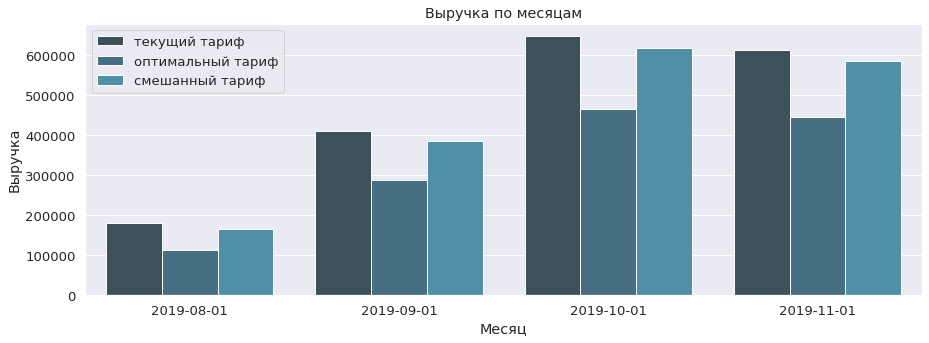

,month,total_rev,optimal_teriff_rev,alternativ_rev,diff_opt,%_opt,diff_alter,%_alter
0,2019-08-01,179880.0,113496.0,164283.0,66384.0,37.0,15597.0,9.0
1,2019-09-01,409065.0,287319.0,383932.0,121746.0,30.0,25133.0,6.0
2,2019-10-01,646086.0,463999.0,617229.0,182087.0,28.0,28857.0,4.0
3,2019-11-01,611284.0,443792.0,585689.0,167492.0,27.0,25595.0,4.0


In [112]:
# сравним общую выручку при использовании разных тарифов

#сгруппируем данные для отображения
plot_tot_rev_opt_rev = df_rev_total.groupby('month')['alternativ_rev'].sum().reset_index()

#преобразуем фрейм для удобства визуализации
c = plot_tot_rev_opt_rev = df_rev_total.groupby('month')['alternativ_rev'].sum().reset_index()
c['month'] = c['month'].astype('str')
c['type'] = 'смешанный тариф'

c.columns = ['month', 'rev', 'type']

df_plot = df_plot.append(c)
df_plot = df_plot.reset_index(drop = True)

#построим график 
sns.barplot(data = df_plot, x = 'month', y ='rev', hue ='type' )
plt.legend()
plt.title('Выручка по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.show()

df_rev_total_opt_grp = df_rev_total.groupby('month')[['total_rev', 'optimal_teriff_rev', 'alternativ_rev']].sum()
df_rev_total_opt_grp['diff_opt'] = df_rev_total_opt_grp['total_rev'] - df_rev_total_opt_grp['optimal_teriff_rev']
df_rev_total_opt_grp['%_opt'] = ((df_rev_total_opt_grp['diff_opt']/ df_rev_total_opt_grp['total_rev'])*100).round(1)

df_rev_total_opt_grp['diff_alter'] = df_rev_total_opt_grp['total_rev'] - df_rev_total_opt_grp['alternativ_rev']
df_rev_total_opt_grp['%_alter'] = ((df_rev_total_opt_grp['diff_alter']/ df_rev_total_opt_grp['total_rev'])*100).round(1)


df_rev_total_opt_grp.reset_index()

In [83]:
print('Средний процент снижения выручки при использовании оптимального тарифа: {:.2f}'.format(df_rev_total_opt_grp['%_alter'].mean()))

Средний процент снижения выручки при использовании оптимального тарифа: 5.87


### Вывод
В результате ретроспективного анализа применения __схемы 30 - 10__ - перевода __30%__ клиентов с неоптимальными тарифами на оптимальный и __10%__ с оптимальными на второй по оптимальности удалось выявить что в среднем размер выручки был бы меньше на __5.87%__ процента в месяц, вместо __30.5%__ при предложении только оптимального тарифа.

## Проверка статистических гипотез

### Гипотеза о равенстве выручки при использовании текущего и оптимального тарифов

Соформулируем гипотезу для проверик:

* Нулевая - Выручка при использовании текущего тарифа равна выручке при использовании оптимального.
* Альтернативная - Не верно, что выручка при использовании текущего тарифа равна выручке при использовании оптимального.

In [84]:
#определим выборки для последующих тестов
current_tatiff= df_rev_total['total_rev']
optimal_tariff  = df_rev_total['optimal_teriff_rev']
alternative_tariff = df_rev_total['alternativ_rev']

In [85]:
stat, p = levene(current_tatiff, optimal_tariff)
p

0.0004485225377320287

Результат по тесту Левене не превышает 0,05. Это говорит нам о том, что дисперсии не гомогенны, при проверке испльзуем параметр equel_var = False

In [108]:

alpha = 0.01

results = st.ttest_ind(
    current_tatiff,
    optimal_tariff,
    equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.140393886658115e-06
Отвергаем нулевую гипотезу


### Гипотеза о равенстве выручки при использовании текущего и альтернативного тарифов

Соформулируем гипотезу для проверик:

* Нулевая - Выручка при использовании текущего тарифа равна выручке при использовании альтернативного.
* Альтернативная - Не верно, что выручка при использовании текущего тарифа равна выручке при использовании альтернативного.

In [87]:
stat, p = levene(current_tatiff, alternative_tariff)
p

0.6016638980075212

Результат по тесту Левене превышает 0,05. Это говорит нам о том, что дисперсии гомогенны, при проверке используем параметры по умолчанию.

In [88]:
alpha = 0.01

results = st.ttest_ind(
    current_tatiff,
    alternative_tariff)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.4295587295999749
Не получилось отвергнуть нулевую гипотезу


### Вывод.

В результате статистической проверки удалось отвергнуть гипотезу о равенстве выручки при использовании текущего и оптимального тарифов и не удалось отвергунуть гипотезу о рпвенстве выручки при использовании текущего и альтернативного тарифа (схема 30-10). 
Из чего следует, что при смешенном предложении о переходе на тарифы статистически значимая разница в выручке отсутствует.

## Общий вывод.

В ходе исследованы были проанализированы дынные пользователей телеком компаний. 
Всего 307 пользователей в результате предобработки из анализыа были иселючены неактивные пользователи (менее 10 звонков за месяц) - всего 45 пользователей.

На основе очищенных от аномальных пользователей данных был составлен следующи __портрет типичного клиента:__

В среднем клиет использует в работе 2 -х операторов в смене, как правиоло работает 1 сотрудник. 

В день один сорудник в среднем 

__совершает:__

- 11 исходящих звонков на внешние номера общей длительностью 19 минут
- 4 исходящих звонка на внутренние номера общей длительностью 5 минут

__принимает:__

- 4 звонка с внешних номеров общей длительностью 3 минуты
- 1 звонок с внутренних номеров общей длительностью 1 минута

В среднем 5 звонков на сотрудника в день являются пропущенными.



Основаная часть проекта былпа посвещена расчету показателей выручки при использовании текущего и оптимального тарифов, а так же предложению по оптимизации потери выручки. 

В ходе исследования были получены следущие результаты: 

* Общая выручка на текущем тарифе:  __1846315 рублей__

* Наибольшая в октябре -  __646086 рублей__
* Наименьшая в августе -  __179880 рублей__


Больше всего неоптимальными тарифами клиенты пользовались в октябре и ноябре - 109 и 108 клиентов с неоптимальными тарифами.


Размер общей выручки при использовании клиентами оптимальных тарифов - __1308606 рублей__

В сравнении с текущим тарифом размер выручки меньше на __30.5%__
Больше всего неоптимальными тарифами клиенты пользовались в октябре и ноябре - 108 и 109 клиентов с неоптимальными тарифами.

Чаще всего клиента выгоднее переходить на тариф С, данный тариф был чаще всего. Количество рекомендованных тарифов при импользовании неоптимального в месяц:
* C - 659
* B	- 17
* A	- 5

В части по оптимизации выручке была предложена схема смешанного перевода клиентов - 30% с неоптимальнымии тарифами на оптимальный и 10% с оптимальными тарифами на второй по оптимальномти. В результате расчетов удалось определить, что при данной схеме ретромпективно выручка снизилась на __5,2%__ вместо __30.5%__ при условии использования клиентами только оптимальных тарифов.

В заключительной части проекта были проверены следующие гипотезы:

* Гипотеза о равенстве выручки при использовании текущего и оптимального тарифов
* Гипотеза о равенстве выручки при использовании текущего и альтернативного тарифов

В результате проведения статистических тестов удалось выявить, что выручка статистически различается на текущих и оптимальных тарифах и статичтически не различается на текущихи альтернативных (схема 30-10) тарифах.